# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 


# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj




In [1]:
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd

In [2]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
import seaborn as sns


In [3]:
workdir='/Users/Keren/anaconda3/envs/Chem101_S24/Work/'
datadir='/Users/Keren/anaconda3/envs/Chem101_S24/data/'
outdir='/Users/Keren/anaconda3/envs/Chem101_S24/out/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

#if not os.path.exists(workDir):
    #os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/Users/Keren/anaconda3/envs/Chem101_S24/data/butane.pdb
/Users/Keren/anaconda3/envs/Chem101_S24/data/butane.gaff2.xml


In [4]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127867 kJ/mol
Potential energy after minimization is 5.295271861905595 kJ/mol


In [5]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,49.88223613923523,246.6529472170107
2000,32.90421998731842,352.10597039417684


In [6]:
os.path.join(workdir, "butane_sim.xtc")

'/Users/Keren/anaconda3/envs/Chem101_S24/Work/butane_sim.xtc'

In [7]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_sim.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,42.731287780735926,298.2449838579453,--
500000,999.9999999901769,36.83799607186965,367.8703493123168,9.1e+03
750000,1499.9999999783536,36.99522236571583,342.9946108405575,9.32e+03
1000000,1999.9999999665301,40.818302316487085,261.19236398890035,9.24e+03
1250000,2499.9999999547067,47.761115071581756,293.9575537908401,9.41e+03
1500000,2999.9999999428833,35.441115470736975,385.96613131050316,9.54e+03
1750000,3499.99999993106,36.11849170924134,232.109550592369,9.58e+03
2000000,3999.9999999192364,46.058320918653195,220.3956127511215,9.6e+03
2250000,4499.9999999992715,48.51013964307748,302.70997281236777,9.64e+03
2500000,5000.000000101135,48.49955090069167,420.4680409828327,9.69e+03
2750000,5500.000000202998,44.68775343754524,458.738645043439,9.75e+03
3000000,6000.000000304862,47.40023416586068,240.01226730959314,9.68e+03
3250000,6500.000000406725,49.768055145987

In [8]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)
traj


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x259f7be9050>

In [9]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [10]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x25982f4b950>

In [11]:
C_sel=top.select("type C")
print(C_sel)
top.atom(10)
for atom in C_sel:
    print(atom,top.atom(atom))

H_sel=top.select("type H")
for atom in H_sel:
    print(atom,top.atom(atom))

[ 0  4  7 10]
0 NBU1-C1
4 NBU1-C2
7 NBU1-C3
10 NBU1-C4
1 NBU1-H11
2 NBU1-H12
3 NBU1-H13
5 NBU1-H21
6 NBU1-H22
8 NBU1-H31
9 NBU1-H32
11 NBU1-H41
12 NBU1-H42
13 NBU1-H43


In [12]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


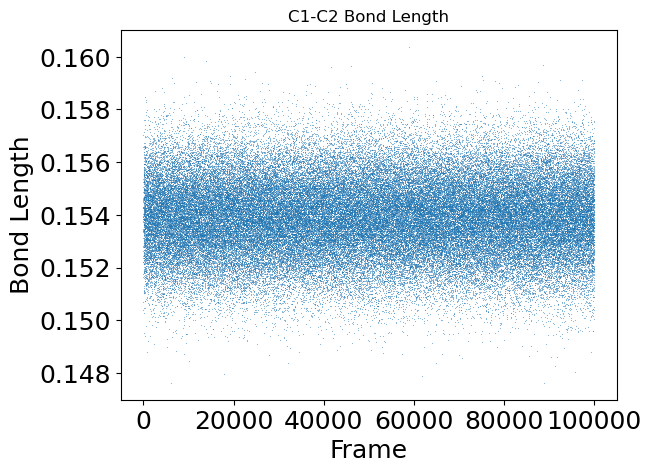

In [13]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C1C2bondlength,linewidth=1)
plt.plot(C1C2bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
#plt.xlim([0,1000]) ## used to set the limit of the axis

plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

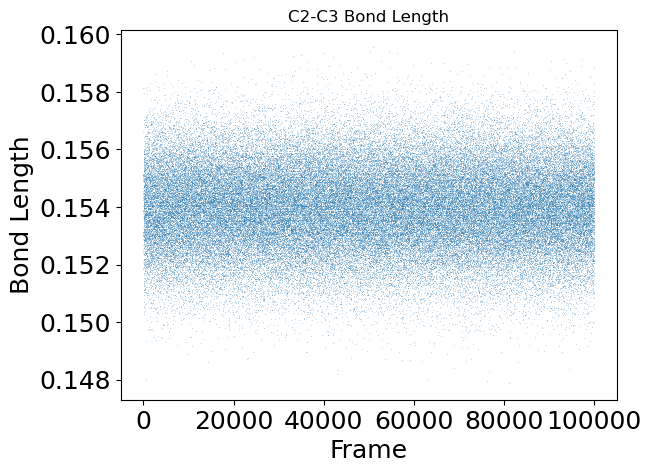

In [14]:
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C2C3bondlength)
plt.plot(C2C3bondlength,linewidth=0,marker='x',markersize=.05)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

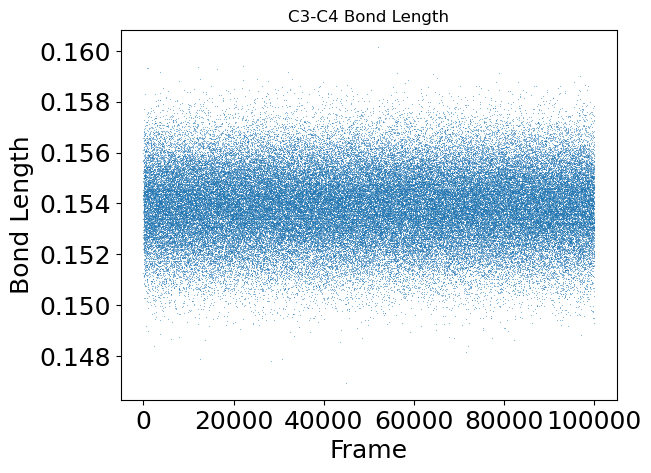

In [15]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C3C4bondlength)
plt.plot(C3C4bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

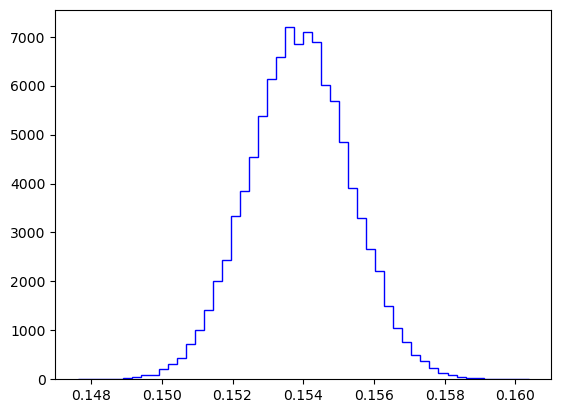

In [16]:
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.show()

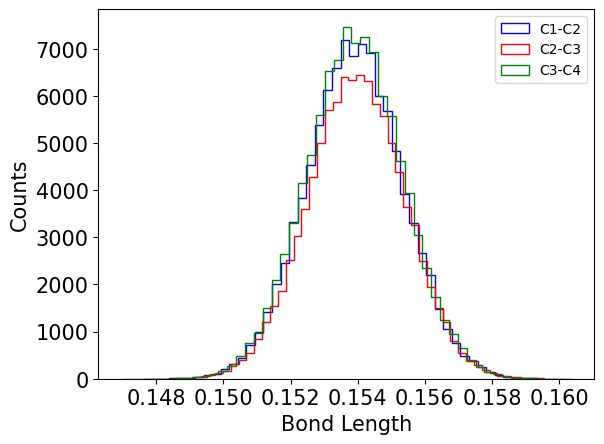

In [17]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [18]:
###SOLUTION###
def variance(data):
    ave=np.average(data)
    var= np.average((data-ave)**2)
    std=var**0.5
    return var,std

C1C2var,C1C2std=variance(C1C2bondlength)
C2C3var,C2C3std=variance(C2C3bondlength)
C3C4var,C3C4std=variance(C3C4bondlength)

print("C1-C2 variance:",C1C2var,"C1-C2 standard deviation:",C1C2std)
print("C2-C3 variance:",C2C3var,"C1-C2 standard deviation:",C2C3std)
print("C3-C4 variance:",C2C3var,"C1-C2 standard deviation:",C3C4std)

C1-C2 variance: 2.0605462e-06 C1-C2 standard deviation: 0.00143546027256622
C2-C3 variance: 2.065617e-06 C1-C2 standard deviation: 0.0014372254805094507
C3-C4 variance: 2.065617e-06 C1-C2 standard deviation: 0.0014373090884707315


In [19]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

C1-C2 average: 0.1539016 variance: 2.0605462e-06 std-dev: 0.0014354603
C2-C3 average: 0.15395819 variance: 2.065617e-06 std-dev: 0.0014372255
C3-C4 average: 0.15389971 variance: 2.0658574e-06 std-dev: 0.0014373091


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


In [20]:
#Switch to a 1D array 
np.shape(C1C2bondlength[:,0])

(100000,)

Line Parameters: [0.50015977 0.07697874]


C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\IPython\core\interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


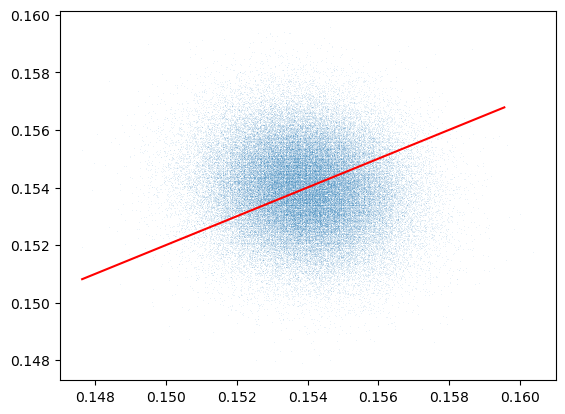

r2: -0.10394286663430671
Line Parameters: [0.49997235 0.0769499 ]


C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\IPython\core\interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


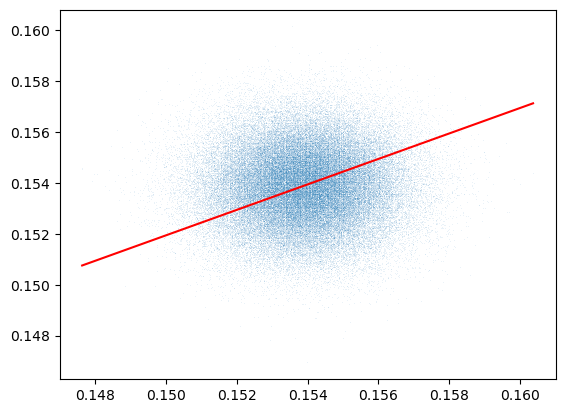

r2: 0.013557818235407366


In [21]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',s=0.1,linewidth=0.05)

#######SOLUTION###########


line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)

line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

C:\Users\Keren\AppData\Local\Temp\ipykernel_22376\3437912455.py:2: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ve

<Figure size 640x480 with 0 Axes>

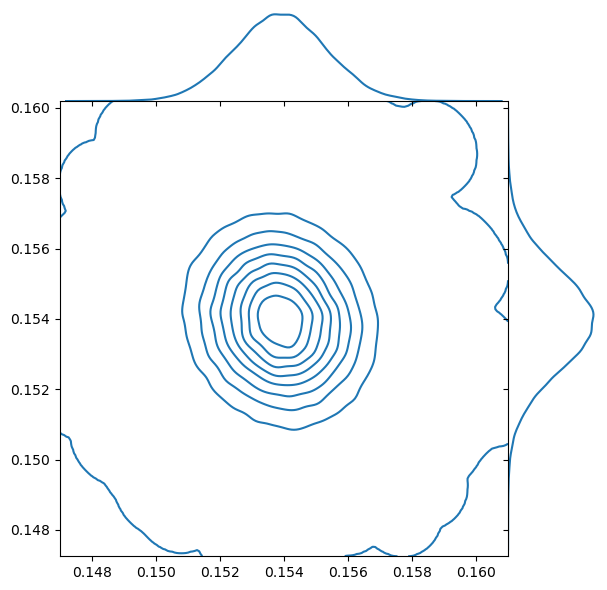

In [23]:
import seaborn as sns
with pd.option_context('mode.use_inf_as_na', True):
    plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='kde',space=0,thresh=0)

C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

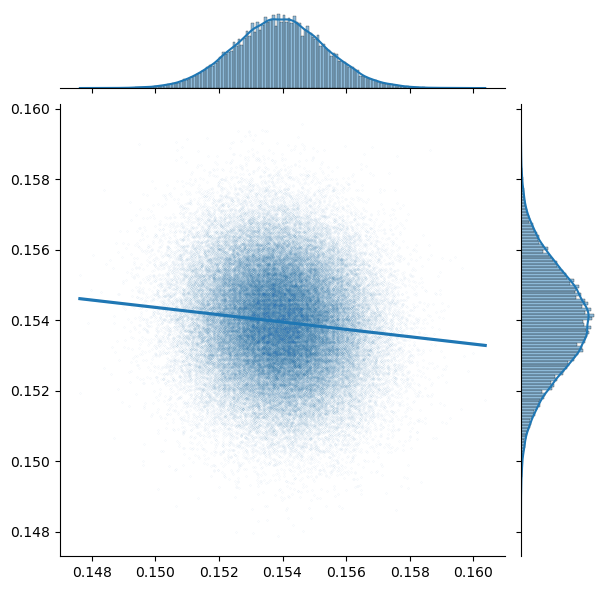

In [25]:
import seaborn as sns
#with pd.option_context('mode.use_inf_as_na', True):
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='reg',scatter_kws={'s':0.001})

**WEEK 1 Homework Question:  Why does one pair of these bonds appear slightly more correlated than the other?**

HERE IS MY ANSWER - The calculated coefficient of correlation for C1C2/C2C3 bond pair (A) is r^2: -0.1088523445317443 and that of C1C2/C3C4 bond pair (B) is r^2: 0.012420380154027818. from the results, A is more correlated than B since the r^2 value observed for A is close to -1 than the r^2 value observed for B being close to 1. This observation makes A more correlated than B, and this can be due to the stearic hinderance between the hydrogen atoms of A. Since they share a common carbon atom (C2), the rotation angles could results in a greater stearic hinderance when a fully eclipse conformation is obtained as opposed to B which doesn't share a common attom.  

***Class Activity*** 

***Lets write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

[    2     4    21   118   397  1277  3233  6778 11220 15972 17813 16792
 12349  7717  3940  1575   598   147    40     5] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]
a: 0.17964291395285503 x_0: 0.1539001467154132 fit_sigma: -0.0014418156774499242


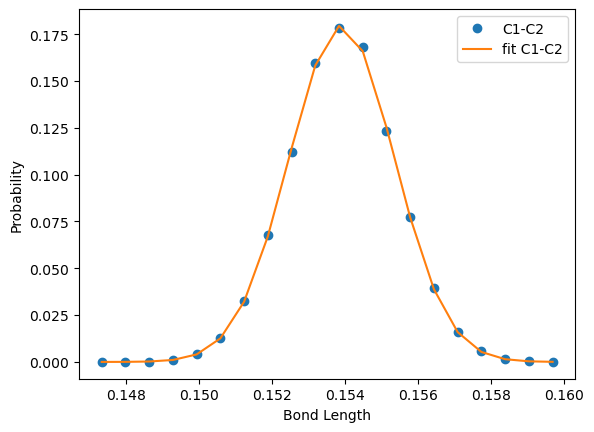

In [26]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit

####SOLUTION####

#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:

counts, edges = np.histogram(C1C2bondlength,bins=20,range=[0.147,0.160])
print(counts,edges)
centers = edges[:-1] + np.diff(edges)/2
density=counts/(np.sum(counts))

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR HOMEWORK ####

###Now we define a gaussian function that we'll fit to our probability densities
def gauss(x,a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss,x,y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x_0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(x,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]


C1C2_fit,C1C2_fit_params=fit_gauss(centers,density)

plt.plot(centers,density,'o',label='C1-C2')
plt.plot(centers,C1C2_fit,'-',label='fit C1-C2')
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')
plt.show()

#C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)


***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

a: 0.17964291395285503 x_0: 0.1539001467154132 fit_sigma: -0.0014418156774499242
a: 0.1790042876847628 x_0: 0.15396134989819268 fit_sigma: -0.0014492302749275776
a: 0.17891474809377944 x_0: 0.1539058931866217 fit_sigma: -0.0014488087908785666


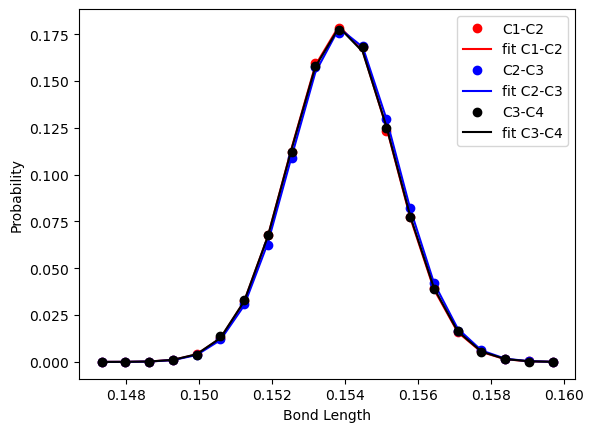

In [27]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####HOMEWORK SOLUTION####
#def histogram_bincenters:
def histogram_bincenters(bondlengths, a_bins, a_range):
    ### bondlengths is md calculated from the np.array, bins is an integer representing the number of bins and range is lists the minimum and maximum
   
####ADD YOUR CODE HERE #####
#  return centers,density 
    counts, edges = np.histogram(bondlengths, bins=a_bins, range=a_range)
    centers=edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
    return centers, density

#USE THE FUNCTION TO ITERATE OVER ALL CC BONDS, plot the densities and the fits
# get centers and density for C1C2bondlength
centers, density = histogram_bincenters(C1C2bondlength, a_bins=20, a_range=[0.147,0.160])
C1C2_fit,C1C2_fit_params=fit_gauss(centers,density)
plt.plot(centers,density,'o',color= 'red', label='C1-C2')
plt.plot(centers,C1C2_fit,'-', color= 'red', label='fit C1-C2')

# get centers and density for C2C3bondlength
centers, density = histogram_bincenters(C2C3bondlength, a_bins=20, a_range=[0.147,0.160])
C2C3_fit,C2C3_fit_params=fit_gauss(centers,density)
plt.plot(centers,density,'o', color= 'blue', label='C2-C3')
plt.plot(centers,C2C3_fit,'-',color= 'blue', label='fit C2-C3')

# get centers and density for C3C4bondlength
centers, density = histogram_bincenters(C3C4bondlength, a_bins=20, a_range=[0.147,0.160])
C3C4_fit,C3C4_fit_params=fit_gauss(centers,density)
plt.plot(centers,density,'o',color= 'black', label='C3-C4')
plt.plot(centers,C3C4_fit,'-',color= 'black', label='fit C3-C4')


# this is for the general plot 
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')
plt.show()

**Week 1 Homework Problem #2: convert these probability distributions to culmulative distribution functions**

In [28]:
###WEEK 1 HOMEWORK#### 

####HOMEWORK SOLUTION####

#TRY THIS FUNCTION:
#https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html
#ADD CODE FOR CDFs HERE#   

def histogram_bincenters(bondlengths, a_bins, a_range):
    ### bondlengths is md calculated from the np.array, bins is an integer representing the number of bins and range is lists the minimum and maximum

    counts, edges = np.histogram(bondlengths, bins=a_bins, range=a_range)
    centers=edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
    return centers, density
    
def pdf_to_cdf(density):
    
     # Calculate the cumulative sum of the density
    cumulative_density = np.cumsum(density)

    return cumulative_density

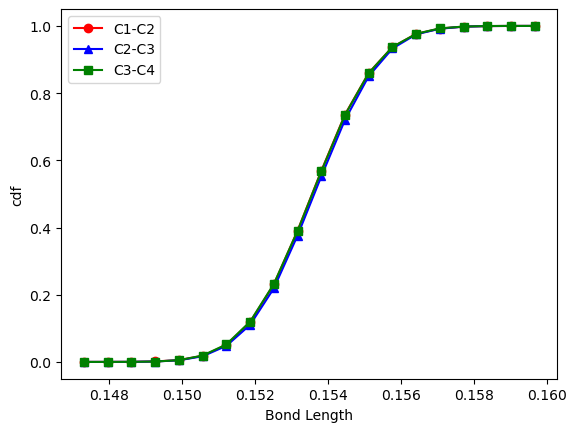

In [29]:
# get cdf for C1C2bondlength
centers, density = histogram_bincenters(C1C2bondlength, a_bins=20, a_range=[0.147, 0.160])
cdf = pdf_to_cdf(density)
plt.plot(centers, cdf, 'o', linestyle="-", color= 'red', label='C1-C2')

# get cdf for C2C3bondlength
centers, density = histogram_bincenters(C2C3bondlength, a_bins=20, a_range=[0.147,0.160])
cdf = pdf_to_cdf(density)
plt.plot(centers, cdf,'^', linestyle="-", color= 'blue', label='C2-C3')

# get cdf for C3C4bondlength
centers, density = histogram_bincenters(C3C4bondlength, a_bins=20, a_range=[0.147,0.160])
cdf = pdf_to_cdf(density)
plt.plot(centers, cdf,'s', linestyle="-", color= 'green', label='C3-C4')

# this is for the general plot 
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('cdf')
plt.show()



**WEEK 1 Homework Problem #3: Lets draw some random frames from our trajectory (for example 10,100,1000,10000),  calculate the probability distribution functions for 4 of these random samples, and fit  gaussians to these probability distirbution functions for 1) A Bond Angle 3) A Dihedral Angle.  Why is the Gaussian fit for a dihedral so poor with a large sample? ***

Frame number selected: 10
a: -1.2472166846620327 x_0: -1.168770766736653 fit_sigma: -0.14421572138833036
a: 0.19063270652616737 x_0: 0.15442504283337577 fit_sigma: 0.0012713198814894933
a: -4.352760569812907 x_0: -6.563958088062344 fit_sigma: 0.6342566268688503


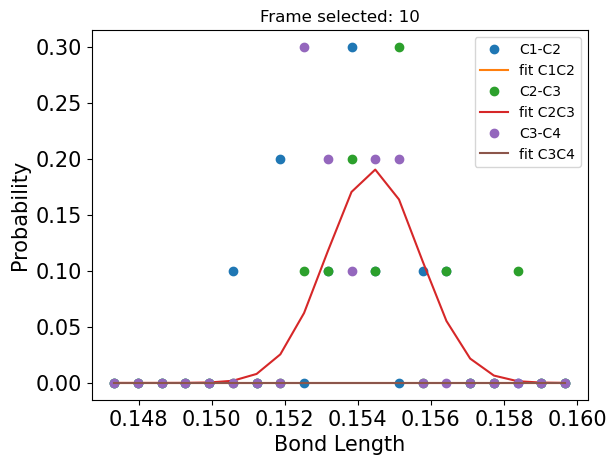

Frame number selected: 100
a: 0.17505313916296306 x_0: 0.15424942652479795 fit_sigma: 0.0015305863352650766
a: -1.3770031720785163 x_0: -2.0189559289561743 fit_sigma: -0.17572325437746222
a: 0.17115149499743432 x_0: 0.1539894534262169 fit_sigma: 0.0015428948526531668


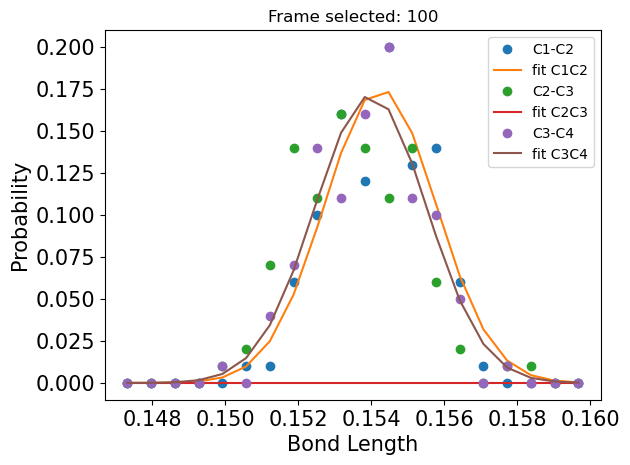

Frame number selected: 1000
a: 0.1808630907767472 x_0: 0.15385499234562353 fit_sigma: -0.0014339710980606037
a: 0.1753034061443295 x_0: 0.15387488843531613 fit_sigma: -0.0014869838523685224
a: 0.1794821157358499 x_0: 0.1539600622495491 fit_sigma: -0.0014399092431557645


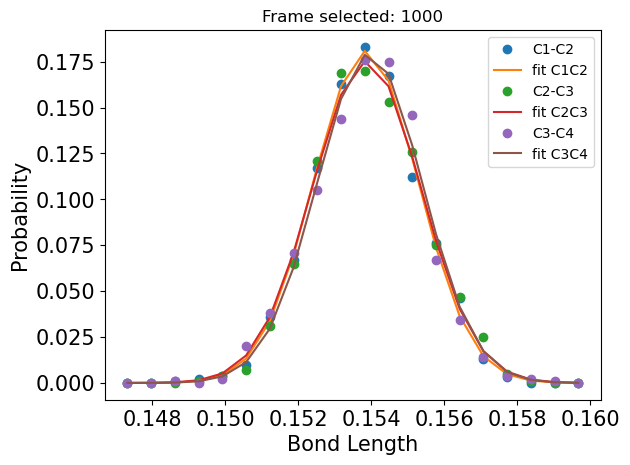

Frame number selected: 10000
a: 0.1814326368972312 x_0: 0.15388049034647744 fit_sigma: 0.001428038773342536
a: 0.1796444803739837 x_0: 0.15391564077489978 fit_sigma: -0.0014426705095739204
a: 0.17923061381936906 x_0: 0.15391595253623744 fit_sigma: -0.0014505492552840575


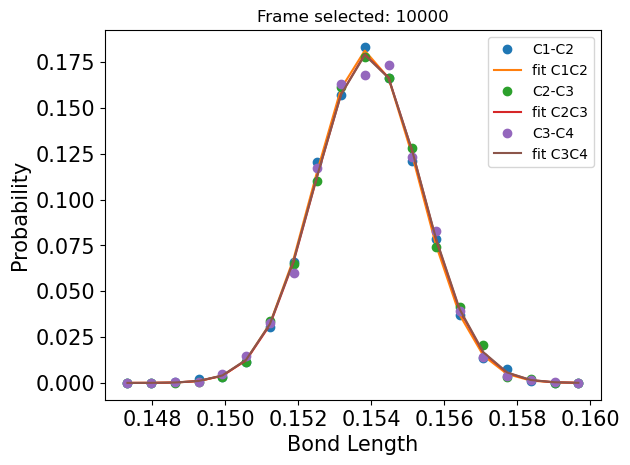

<Figure size 640x480 with 0 Axes>

In [30]:
#Draw 10,100,1000 random samples of a bond angle,
#This function might be helpful:
rands=np.random.randint(10000, size=(10))
rands
#ADD CODE FOR Random Samples here#
#Draw 10,100,1000 random samples of a bond angle,

def histogram_bincenters(bondlengths, a_bins, a_range):
    ### bondlengths is md calculated from the np.array, bins is an integer representing the number of bins and range is lists the minimum and maximum

    counts, edges = np.histogram(bondlengths, bins=a_bins, range=a_range)
    centers=edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
    return centers, density
    
centers, density = histogram_bincenters(C1C2bondlength, 20, [0.147, 0.160])

#This function might be helpful:
frame_length = [10,100,1000,10000]
for i in frame_length:
    rands=np.random.randint(10000, size=(i))
    print('Frame number selected: ' + str(i))

    C1C2_A = C1C2bondlength[rands]
    centers, density = histogram_bincenters(C1C2_A, 20, [0.147, 0.160])
    C1C2_A_fit, C1C2_A_fit_params = fit_gauss(centers,density)
    plt.plot(centers, density, 'o', label = 'C1-C2')
    plt.plot(centers, C1C2_A_fit, '-', label='fit C1C2')
    
    C2C3_A = C2C3bondlength[rands]
    centers, density = histogram_bincenters(C2C3_A, 20, [0.147, 0.160])
    C2C3_A_fit, C2C3_A_fit_params = fit_gauss(centers, density)
    plt.plot(centers, density, 'o', label = 'C2-C3')
    plt.plot(centers, C2C3_A_fit, '-', label='fit C2C3')
    
    C3C4_A = C3C4bondlength[rands]
    centers, density = histogram_bincenters(C3C4_A, 20, [0.147, 0.160])
    C3C4_A_fit, C3C4_A_fit_params = fit_gauss(centers, density)  
    plt.plot(centers, density, 'o', label = 'C3-C4')
    plt.plot(centers, C3C4_A_fit, '-', label='fit C3C4')
    
    plt.legend()
   
    plt.title('Frame selected: ' + str(i))
    plt.xlabel('Bond Length', size=15)
    plt.xticks(size=15)
    plt.ylabel('Probability', size=15)
    plt.yticks(size=15)
    
    plt.show()
    plt.clf()

In [ ]:
#ADD CODE FOR FITTING GUASSIAN FUNCTIONS TO RANDOM SAMPLES  HERE#
#Draw 10,100,1000 random samples of a bond angle - FIT THEM TO BOND ANGLE

#This function might be helpful:
rands=np.random.randint(100000, size=(10))
rands
C1C2bond=C1C2bondlength[:,0]
C1C2bond[rands]
plt.hist(C1C2bond[rands],bins=20,histtype='step')
#Draw 10,100,1000,10000 random samples of a dihedral angle - FIT THEM TO A GAUSSIAN - WHY IS THIS FIT SO POOR?

In [32]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their histograms.  Find a nice way to visualize the C-C-C-C dihedral angle 

(100000, 2)
[[1.95495   2.086188 ]
 [1.951911  1.9877387]
 [2.0675695 1.9576725]
 ...
 [1.8101093 2.0336802]
 [1.8778837 1.9791837]
 [1.9357629 1.9861207]]


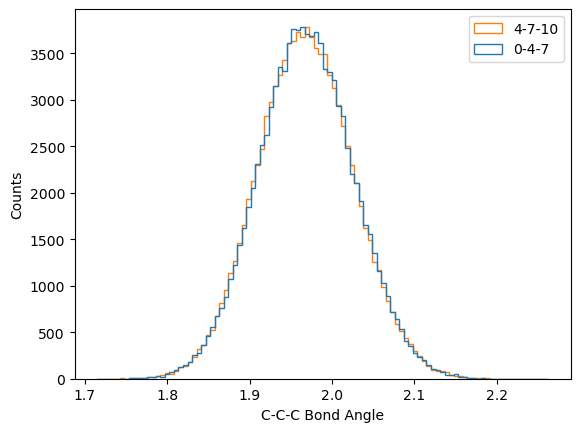

[[-3.047159 ]
 [-3.0306098]
 [ 3.0002484]
 ...
 [-3.0467136]
 [-3.0414343]
 [ 3.0976655]]
[[-174.58934]
 [-173.64114]
 [ 171.90157]
 ...
 [-174.56383]
 [-174.26134]
 [ 177.48315]]


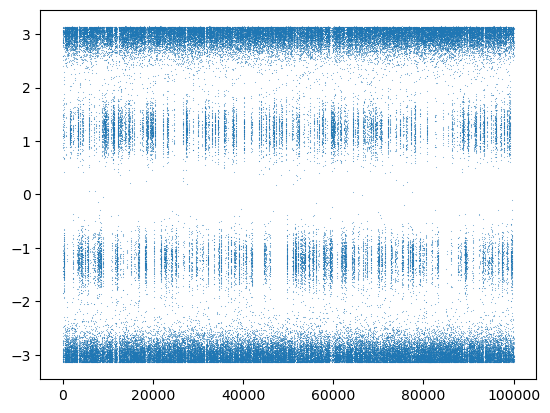

In [31]:
###Class Room Solution###
##Lets Compute Some Bond Angles & Torsions##
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
print(np.shape(ang))
print(ang)

ang1=ang[:,0]
ang2=ang[:,1]

plt.plot(ang1,linewidth=0,marker='x',markersize=.1)
plt.plot(ang2,linewidth=0,marker='x',markersize=.1)
plt.clf()

plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle')
plt.ylabel('Counts')
plt.show()
#plt.scatter(ang1,marker='o',s=0.1)

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
print(CCCC_torsion)
print(np.rad2deg(CCCC_torsion))

plt.plot(CCCC_torsion,marker='x',markersize=.1,linewidth=0)
#plt.xlim([0,100])

Frame number selected:  10
[1.30938198 0.         0.         0.         0.         0.32734562
 0.         0.         0.         0.         0.         0.
 0.         0.32734543 0.         0.         0.         0.
 0.         1.30938198] [-3.0376737  -2.732186   -2.4266984  -2.1212108  -1.8157232  -1.5102355
 -1.204748   -0.89926034 -0.59377277 -0.28828514  0.0172025   0.32269013
  0.62817776  0.93366534  1.239153    1.5446405   1.8501282   2.1556158
  2.4611034   2.766591    3.0720787 ]
a: 10.063427990854272 x_0: -3.1992224088982333 fit_sigma: -0.12374874082169236


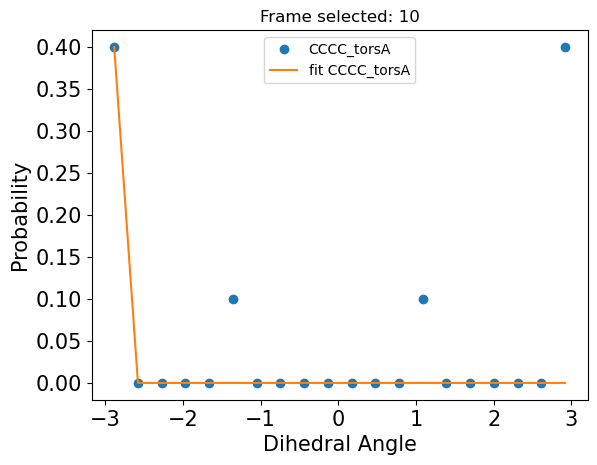

Frame number selected:  100
[1.18108046 0.09576321 0.03192109 0.         0.09576324 0.09576324
 0.09576326 0.09576324 0.         0.         0.         0.
 0.03192108 0.19152652 0.09576324 0.         0.         0.
 0.22344748 0.9576328 ] [-3.125962   -2.8126895  -2.4994168  -2.1861444  -1.8728718  -1.5595992
 -1.2463266  -0.93305403 -0.61978143 -0.30650887  0.0067637   0.32003626
  0.6333088   0.9465814   1.259854    1.5731266   1.8863991   2.1996717
  2.5129442   2.826217    3.1394894 ]
a: 93526902030.7979 x_0: -9.77880083870153 fit_sigma: -0.9396905808852103


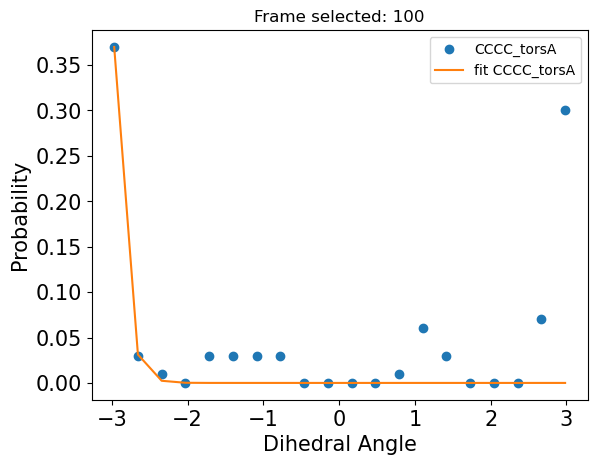

Frame number selected:  1000
[0.95517573 0.18148339 0.03183922 0.00636784 0.05412662 0.20695474
 0.22287442 0.03820703 0.00318392 0.         0.00318392 0.00318392
 0.04775879 0.16874778 0.11143717 0.02228743 0.00636784 0.01910353
 0.22605826 0.87557776] [-3.1406906e+00 -2.8266122e+00 -2.5125339e+00 -2.1984558e+00
 -1.8843775e+00 -1.5702991e+00 -1.2562208e+00 -9.4214261e-01
 -6.2806427e-01 -3.1398600e-01  9.2267990e-05  3.1417054e-01
  6.2824881e-01  9.4232714e-01  1.2564054e+00  1.5704837e+00
  1.8845620e+00  2.1986403e+00  2.5127184e+00  2.8267968e+00
  3.1408751e+00]
a: 3091072950878739.0 x_0: -17.172478054687392 fit_sigma: -1.652286471104478


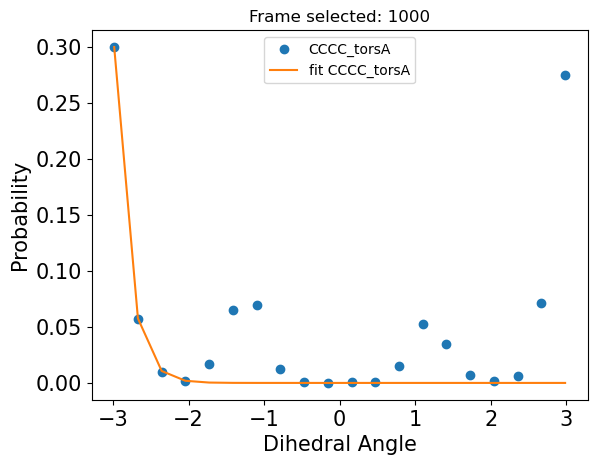

Frame number selected:  10000
[9.65800909e-01 2.08185324e-01 2.73760518e-02 7.63982262e-03
 4.10640622e-02 1.54706467e-01 1.79217574e-01 5.31604526e-02
 7.00317339e-03 1.27330425e-03 6.36652126e-04 4.45656489e-03
 4.74305834e-02 1.87812377e-01 1.18417296e-01 3.40608888e-02
 8.27647450e-03 1.90995710e-02 2.01818801e-01 9.15823736e-01] [-3.1415651e+00 -2.8274217e+00 -2.5132785e+00 -2.1991353e+00
 -1.8849919e+00 -1.5708486e+00 -1.2567053e+00 -9.4256198e-01
 -6.2841868e-01 -3.1427538e-01 -1.3208389e-04  3.1401122e-01
  6.2815452e-01  9.4229782e-01  1.2564411e+00  1.5705844e+00
  1.8847277e+00  2.1988711e+00  2.5130143e+00  2.8271575e+00
  3.1413009e+00]
a: 4.794831367187967 x_0: -4.251293847687652 fit_sigma: -0.5391684357231291


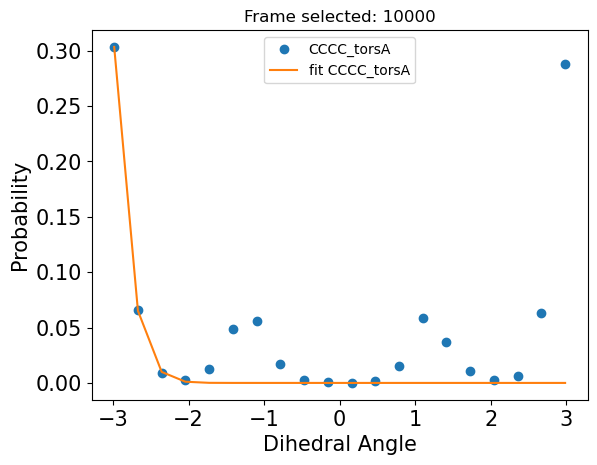

<Figure size 640x480 with 0 Axes>

In [36]:
#ADD CODE FOR FITTING GUASSIAN FUNCTIONS TO RANDOM SAMPLES  HERE#
#Draw 10,100,1000 random samples of a bond angle - FIT THEM TO BOND ANGLE

def histogram_bincenters(CCCC_torsA, bins=20):
    counts, edges = np.histogram(CCCC_torsA, bins=bins, density=True)
    print(counts,edges)
    centers = (edges[:-1] + edges[1:])/2
    density=counts/(np.sum(counts))
    return centers, density

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR HOMEWORK ####

###Now we define a gaussian function that we'll fit to our probability densities
def gauss(x,a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x, y):
    parameters, covariance = curve_fit(gauss, x, y, maxfev=10000)  # Increase maxfev
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:", fit_a, "x_0:", fit_x0, "fit_sigma:", fit_sigma)
    fit_y = gauss(x, fit_a, fit_x0, fit_sigma)
    return fit_y, [fit_a, fit_x0, fit_sigma]

#This function might be helpful:
frame_length = [10,100,1000,10000]
for i in frame_length:
    rands=np.random.randint(10000, size=i)
    print('Frame number selected: ', i)

#CCCC_index=[10,7,4,0]
#CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
    #CCCC_torsion[rands]
    #print(CCCC_torsion)
    #print(np.rad2deg(CCCC_torsion))

    CCCC_torsA = CCCC_torsion[rands]
    centers, density = histogram_bincenters(CCCC_torsA, bins=20,)
    CCCC_torsA_fit, CCCC_torsA_fit_params = fit_gauss(centers,density)
    plt.plot(centers, density, 'o', label = 'CCCC_torsA')
    plt.plot(centers, CCCC_torsA_fit, '-', label='fit CCCC_torsA')

    plt.legend() 
    plt.title('Frame selected: ' + str(i))
    plt.xlabel('Dihedral Angle', size=15)
    plt.xticks(size=15)
    plt.ylabel('Probability', size=15)
    plt.yticks(size=15)
    plt.show()
    plt.clf()

#plt.plot(CCCC_torsion[rands],marker='x',markersize=.1,linewidth=0)
#plt.xlim([0,100])

The poor Gaussian fit results from the multimodal characteristics of butane since it can exist in different conformations.
A Gaussian fit assumes a unimodal symmetric distribution, so it cannot accurately capture the calculated dihedral angles of butane.
Multiple peaks are observed within the 100, 1000, and 10000 random sample plots. For the plot of a sample size of 10, the poor Gaussian fit may result from the outliers and the small sample size. 

(0.0, 1000.0)

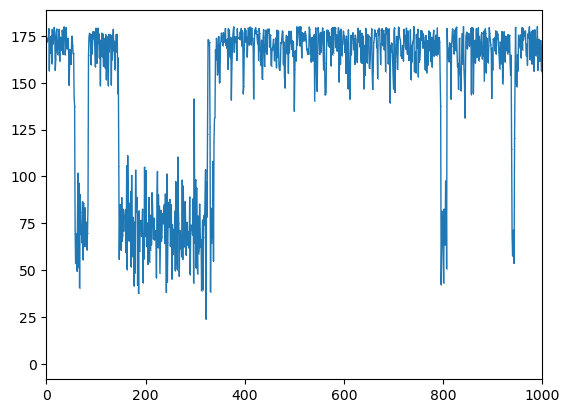

In [37]:
#print(np.where(CCCC_torsion<=0))
CCCC_tor_offset=np.rad2deg(CCCC_torsion)
#print(CCCC_tor_offset)
#for i in range(0,len(CCCC_tor_offset)):
    #if(CCCC_tor_offset[i]<0):
        #CCCC_tor_offset[i]+=360
        
plt.plot(np.abs(CCCC_tor_offset),marker='x',markersize=.1,linewidth=1)
plt.xlim([0,1000])

***Week 1 Homework Question:  What is the probability of being found in the higher free energy C-C-C-C dihedral state?*****

In [38]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe=CCCC_torsion[:,0]
a=np.where(CCCC_dihe<0)
print(a)
print(CCCC_dihe[a])

b=np.where(CCCC_dihe>-2)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe<0) & (CCCC_dihe>-2))
print(c)

#Probability of being between 0 and -2 radians:
print(len(CCCC_dihe[c])/len(CCCC_dihe))


(array([    0,     1,     3, ..., 99995, 99997, 99998], dtype=int64),)
[-3.047159  -3.0306098 -3.0267751 ... -3.074811  -3.0467136 -3.0414343]
(array([    2,     4,     5, ..., 99993, 99996, 99999], dtype=int64),)
(array([  146,   147,   148, ..., 99724, 99725, 99726], dtype=int64),)
0.10579


In [39]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe=CCCC_torsion[:,0]
a=np.where(CCCC_dihe>0)
print(a)
print(CCCC_dihe[a])

b=np.where(CCCC_dihe<5)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe>0) & (CCCC_dihe<5)) # use this function
print(c)
#
# high probability = high energy = unstable (vice versa) 
## what we want to do is show that is has a high energy and the probability of finding something there is low 
#Probability of being between 0 and 5 radians:
print(len(CCCC_dihe[c])/len(CCCC_dihe))

(array([    2,     4,     5, ..., 99993, 99996, 99999], dtype=int64),)
[3.0002484 3.0179734 3.1213245 ... 2.8280854 2.9540894 3.0976655]
(array([    0,     1,     2, ..., 99997, 99998, 99999], dtype=int64),)
(array([    2,     4,     5, ..., 99993, 99996, 99999], dtype=int64),)
0.50116


In [40]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
### Highest energy would be found at 0 rad and 6.25 (360 degrees). but 360 degrees doesn't technically exist so we 
###calculate around the 0 degrees or radiance
 
CCCC_dihe=CCCC_torsion[:,0]
a=np.where(CCCC_dihe<0)
print(a)
print(CCCC_dihe[a])

b=np.where(CCCC_dihe>-0.1)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe<0) & (CCCC_dihe>-0.1)) # use this function
print(c)
#
# low probability = high energy = unstable (vice versa) 
## What we want to do is show that it has high energy and the probability of finding something there is low 
#Probability of being between 0 and -0.1 radians:
print(len(CCCC_dihe[c])/len(CCCC_dihe))

(array([    0,     1,     3, ..., 99995, 99997, 99998], dtype=int64),)
[-3.047159  -3.0306098 -3.0267751 ... -3.074811  -3.0467136 -3.0414343]
(array([    2,     4,     5, ..., 99993, 99996, 99999], dtype=int64),)
(array([ 8838, 66411], dtype=int64),)
2e-05


In [41]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe=CCCC_torsion[:,0]
a=np.where(CCCC_dihe>-6.28)
print(a)
print(CCCC_dihe[a])

b=np.where(CCCC_dihe<6.28)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe>-6.28) & (CCCC_dihe<6.28)) # use this function
print(c)
#
# low probability = high energy = unstable (vice versa) 
## what we want to do is show that is has a high energy and the probability of finding something there is low 
#Probability of being between -6,28 and 6.28 radians:
print(len(CCCC_dihe[c])/len(CCCC_dihe))

(array([    0,     1,     2, ..., 99997, 99998, 99999], dtype=int64),)
[-3.047159  -3.0306098  3.0002484 ... -3.0467136 -3.0414343  3.0976655]
(array([    0,     1,     2, ..., 99997, 99998, 99999], dtype=int64),)
(array([    0,     1,     2, ..., 99997, 99998, 99999], dtype=int64),)
1.0


**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

r2: 0.00021687875007552764


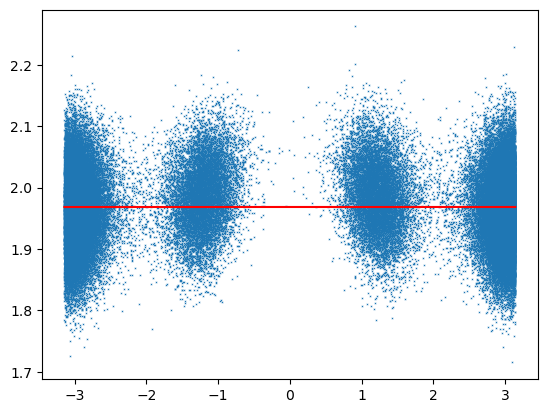

C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Keren\anaconda3\envs\Chem101_S24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

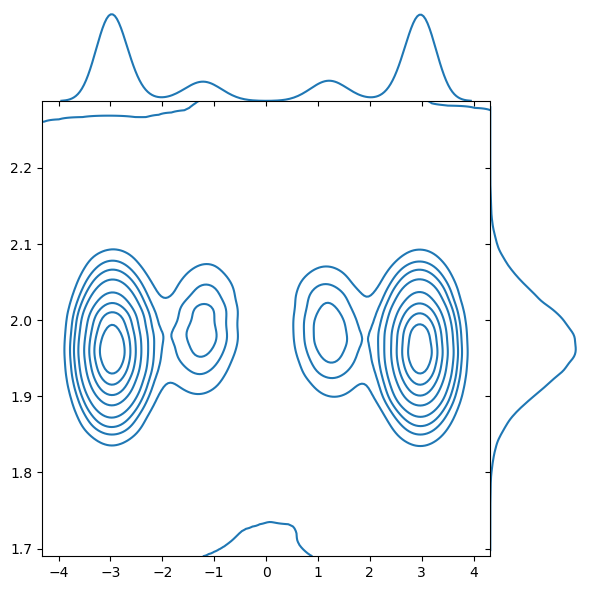

In [42]:
#### COMPLETE IN-CLASS ACTIVITY HERE #####
#Are the bond angle and dihedral correlated?
CCCC_dihe

plt.scatter(CCCC_dihe,ang1,marker='x',s=0.1)
r=np.corrcoef(CCCC_dihe,ang1)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_dihe,ang1,1)
line_fit
x=np.linspace(min(CCCC_dihe),max(CCCC_dihe),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')
plt.show()
##### ADD FANCY SEABORN PLOT HERE ######
sns.jointplot(x=CCCC_dihe,y=ang1,kind='kde',space=0,thresh=0)

**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

In [43]:
#Homework problem 3 Solution ##

#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe
a=np.where(CCCC_dihe<0)
print(a)
CCCC_dihe[a]
b=np.where(CCCC_dihe>-2)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe<0) & (CCCC_dihe>-2))
print(c)
CCCC_dihe[c]

(array([    0,     1,     3, ..., 99995, 99997, 99998], dtype=int64),)
(array([    2,     4,     5, ..., 99993, 99996, 99999], dtype=int64),)
(array([  146,   147,   148, ..., 99724, 99725, 99726], dtype=int64),)


array([-1.8445235, -0.9719996, -1.36326  , ..., -1.2774285, -1.051693 ,
       -1.794245 ], dtype=float32)

In [44]:
#Will Walk through example of Autocorrelation Function (ACF) calculation here#
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)
    
print(ang1)
print(ang1[1:])
print(ang1[:-1])

[1.95495   1.951911  2.0675695 ... 1.8101093 1.8778837 1.9357629]
[1.951911  2.0675695 2.0185127 ... 1.8101093 1.8778837 1.9357629]
[1.95495   1.951911  2.0675695 ... 1.8841634 1.8101093 1.8778837]


**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

[0.00000e+00 2.00002e-01 4.00004e-01 ... 1.99996e+04 1.99998e+04
 2.00000e+04]


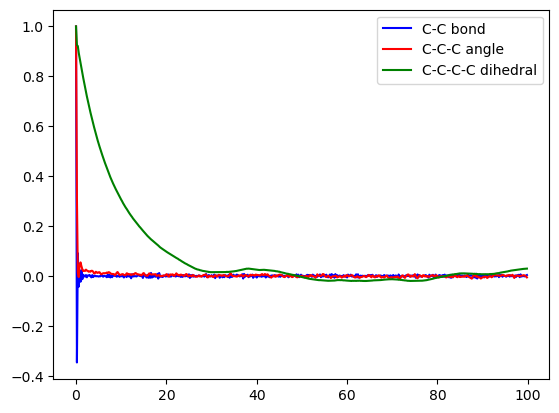

In [45]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

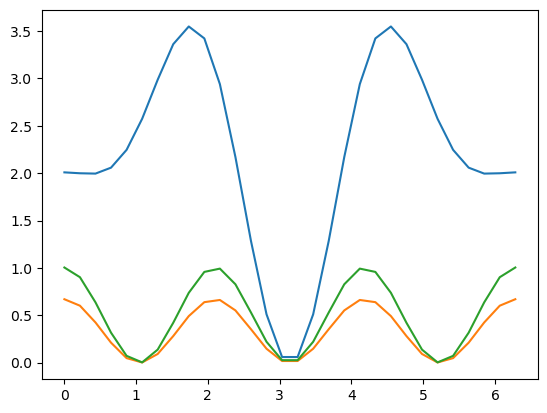

In [46]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)


##Lets write a function to plot the values of force field terms
def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCH_e)
plt.plot(rad_ang,HCCH_e)

In [47]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [48]:
#Lets Consider Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13) why is there a dash between the first bracket and C4 but all others have the C in front of the bracket without a dash?
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Central Torsion: 
#C-C-C-C -[10,7,4,0]
#H-C-C-H; [8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6]  
#H-C-C-H; [6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3]
#H-C-C-H; [13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]
#C-C-C-H -[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

CCCC_index=[10,7,4,0]
HCCH_indices=[[8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6],[6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3],[13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]]
CCCH_indices=[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

HCCH_torsions=md.compute_dihedrals(traj, HCCH_indices)
CCCH_torsions=md.compute_dihedrals(traj, CCCH_indices)
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])


In [49]:
print(HCCH_indices)
print(HCCH_torsions)

[[8, 7, 4, 5], [8, 7, 4, 6], [9, 7, 4, 5], [9, 7, 4, 6], [6, 4, 0, 1], [6, 4, 0, 2], [6, 4, 0, 3], [5, 4, 0, 1], [5, 4, 0, 2], [5, 4, 0, 3], [13, 10, 7, 8], [12, 10, 7, 8], [11, 10, 7, 8], [13, 10, 7, 9], [12, 10, 7, 9], [11, 10, 7, 9]]
[[-3.0029395  -1.0770766   1.463818   ... -2.6411505  -0.7526788
   1.4382752 ]
 [-3.0493715  -0.9699042   1.1782161  ... -2.9496276  -0.8624818
   1.319185  ]
 [ 2.8797212  -1.3921038   0.8783281  ...  2.431309   -1.7200118
   0.5014396 ]
 ...
 [-3.031371   -1.0160099   1.1661484  ... -3.1334326  -1.0282413
   1.1063418 ]
 [-3.048366   -0.93951666  1.0747583  ... -3.1393018  -1.0007433
   1.1001731 ]
 [ 3.0882716  -1.0986413   1.0374297  ...  2.7485206  -1.4930751
   0.7459328 ]]


In [50]:
print(CCCH_indices)
print(CCCH_torsions)

([10, 7, 4, 1], [10, 7, 4, 2], [10, 7, 4, 2], [4, 7, 10, 13], [4, 7, 10, 12], [4, 7, 10, 13])
[[ 2.9011803   3.1064959   3.1064959  -0.35168916  1.5367826  -0.35168916]
 [ 2.977755    2.9234495   2.9234495  -0.88033265  1.2068131  -0.88033265]
 [ 2.5916927   2.879991    2.879991   -1.7459053   0.38595906 -1.7459053 ]
 ...
 [ 2.9173665  -3.1168694  -3.1168694  -0.91662574  1.188566   -0.91662574]
 [ 2.7544599  -2.7548642  -2.7548642  -1.0207127   1.1178458  -1.0207127 ]
 [ 2.6178095  -2.859603   -2.859603   -1.3930583   0.64853126 -1.3930583 ]]


In [51]:
print(CCCC_index)
print(CCCC_torsion)

[10, 7, 4, 0]
[[-3.047159 ]
 [-3.0306098]
 [ 3.0002484]
 ...
 [-3.0467136]
 [-3.0414343]
 [ 3.0976655]]


**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

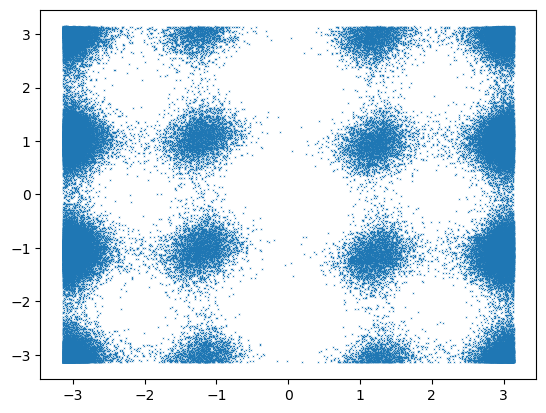

<Figure size 640x480 with 0 Axes>

In [52]:
####WEEK 1 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Perhaps Consider CCCC vs. [8,7,4,5]



#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Perhaps Consider CCCC vs. [12,10,7,9]?

#For Example:
plt.scatter(CCCC_torsion,HCCH_torsions[:,14],marker='x',s=0.05)
plt.show()
plt.clf()


Line Parameters: [0.01284127 0.05730059]
r2: 0.018289355592467443


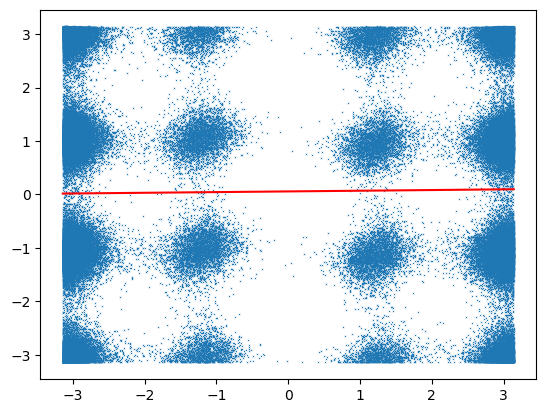

<Figure size 640x480 with 0 Axes>

In [53]:
####WEEK 1 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Perhaps Consider CCCC vs. [8,7,4,5]



#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Perhaps Consider CCCC vs. [12,10,7,9]?
plt.scatter(CCCC_torsion,HCCH_torsions[:,14],marker='x',s=0.05)

line_fit=np.polyfit(CCCC_torsion[:,0],HCCH_torsions[:,14],1)
x = np.linspace(min(CCCC_torsion[:,0]), max(HCCH_torsions[:,14]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')

r=np.corrcoef(CCCC_torsion[:,0], HCCH_torsions[:,14])
print("r2:",r[0,1])

#For Example:
plt.show()
plt.clf()

Line Parameters: [ 0.01570471 -0.1299437 ]
r2: 0.021924133233922404


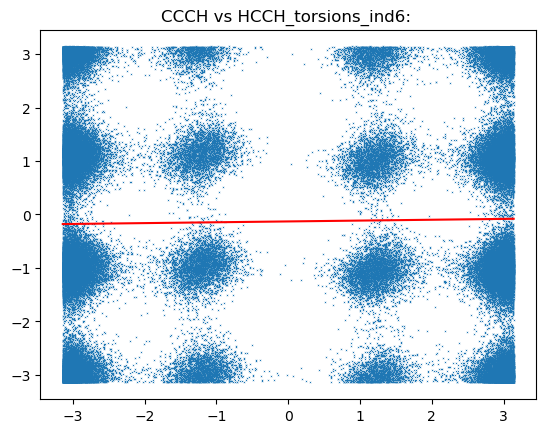

<Figure size 640x480 with 0 Axes>

In [54]:
plt.scatter(CCCC_torsion[:,0], HCCH_torsions[:,6],marker='x',s=0.05)

line_fit=np.polyfit(CCCC_torsion[:,0],HCCH_torsions[:,6],1)
x = np.linspace(min(CCCC_torsion[:,0]), max(HCCH_torsions[:,6]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')

r=np.corrcoef(CCCC_torsion[:,0], HCCH_torsions[:,6])
print("r2:",r[0,1])
plt.title('CCCH vs HCCH_torsions_ind6: ')
plt.show()
plt.clf()

Line Parameters: [0.63072506 0.00308646]
r2: 0.633565452848718


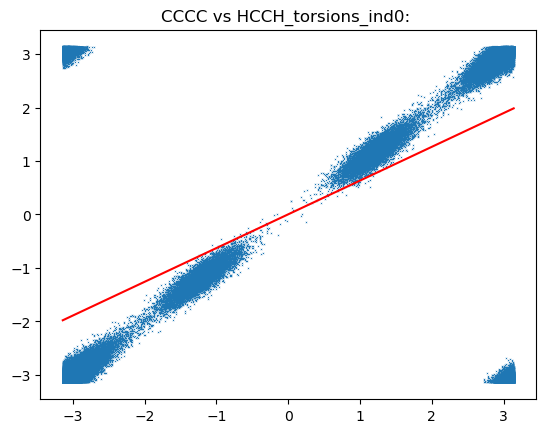

<Figure size 640x480 with 0 Axes>

In [55]:
plt.scatter(CCCC_torsion[:,0], HCCH_torsions[:,0],marker='x',s=0.05)

line_fit=np.polyfit(CCCC_torsion[:,0],HCCH_torsions[:,0],1)
x = np.linspace(min(CCCC_torsion[:,0]), max(HCCH_torsions[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
#plt.show()
#plt.clf()

r=np.corrcoef(CCCC_torsion[:,0], HCCH_torsions[:,0])
print("r2:",r[0,1])
plt.title('CCCC vs HCCH_torsions_ind0: ')
plt.show()
plt.clf()

Explanation: The calculated coefficient of correlation for CCCC/HCCH_[0] pair is r^2: 0.6297988236828581 indicating a strong positive correlation between the two bonds. This shows a strong connection between the hydrogen atoms surrounding the shared carbon atoms that form the bond. This can lead to the prediction of bond changes around the central or shared carbon atom.

Line Parameters: [ 0.01392923 -0.01819358]
r2: 0.019790103931988916


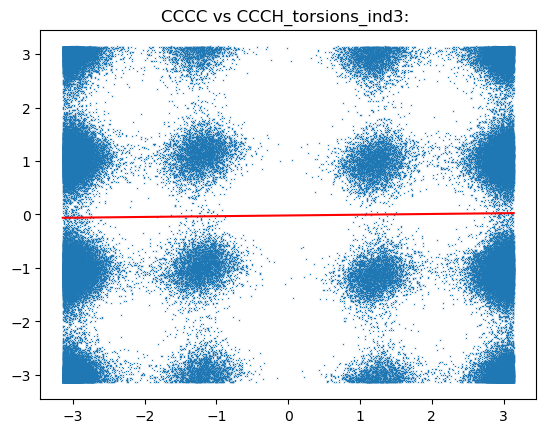

<Figure size 640x480 with 0 Axes>

In [56]:
plt.scatter(CCCC_torsion[:,0], CCCH_torsions[:,3],marker='x',s=0.05)

line_fit=np.polyfit(CCCC_torsion[:,0],CCCH_torsions[:,3],1)
x = np.linspace(min(CCCC_torsion[:,0]), max(CCCH_torsions[:,3]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
#plt.show()
#plt.clf()

r=np.corrcoef(CCCC_torsion[:,0], CCCH_torsions[:,3])
print("r2:",r[0,1])
plt.title('CCCC vs CCCH_torsions_ind3: ')

plt.show()
plt.clf()

Line Parameters: [0.22021005 0.02453231]
r2: 0.2326261736347561


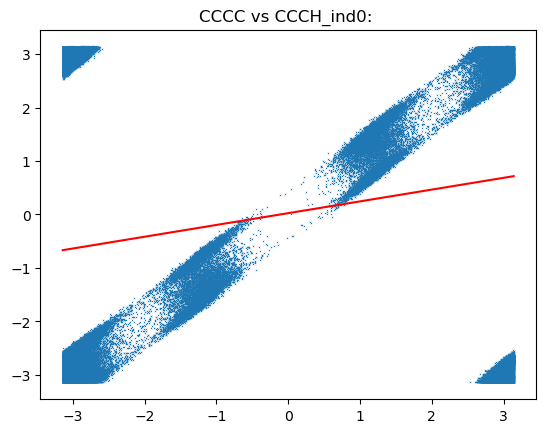

<Figure size 640x480 with 0 Axes>

In [57]:
plt.scatter(CCCC_torsion[:,0], CCCH_torsions[:,0],marker='x',s=0.05)

line_fit=np.polyfit(CCCC_torsion[:,0],CCCH_torsions[:,0],1)
x = np.linspace(min(CCCC_torsion[:,0]), max(CCCH_torsions[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
#plt.show()
#plt.clf()

r=np.corrcoef(CCCC_torsion[:,0], CCCH_torsions[:,0])
print("r2:",r[0,1])
plt.title('CCCC vs CCCH_ind0: ')
plt.show()
plt.clf()

**Homework Problem #6: SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT**

Line Parameters: [-0.16118825 -0.09271886]
r2: -0.15690254961069558


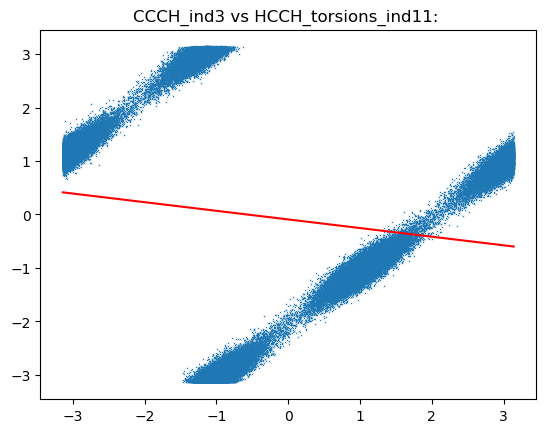

<Figure size 640x480 with 0 Axes>

In [58]:
plt.scatter(CCCH_torsions[:,3], HCCH_torsions[:,11],marker='x',s=0.05)

line_fit=np.polyfit(CCCH_torsions[:,3],HCCH_torsions[:,11],1)
x = np.linspace(min(CCCH_torsions[:,3]), max(HCCH_torsions[:,11]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')

r=np.corrcoef(CCCH_torsions[:,3], HCCH_torsions[:,11])
print("r2:",r[0,1])
plt.title('CCCH_ind3 vs HCCH_torsions_ind11: ')

plt.show()
plt.clf()

In [59]:
# np.concatenate(CCCH_torsions[:,3], HCCH_torsions[:,11])

HCCH_torsions[:,11]

array([-2.5867918, -2.9510128,  2.5660791, ..., -2.991266 , -3.011947 ,
        2.7441878], dtype=float32)

[ -20.150303  -50.439342 -100.033    ...  -52.518784  -58.48253
  -79.81636 ] [-148.21223 -169.08057  147.0255  ... -171.3869  -172.57184  157.23038]
[[-174.58934]
 [-173.64114]
 [ 171.90157]
 ...
 [-174.56383]
 [-174.26134]
 [ 177.48315]]


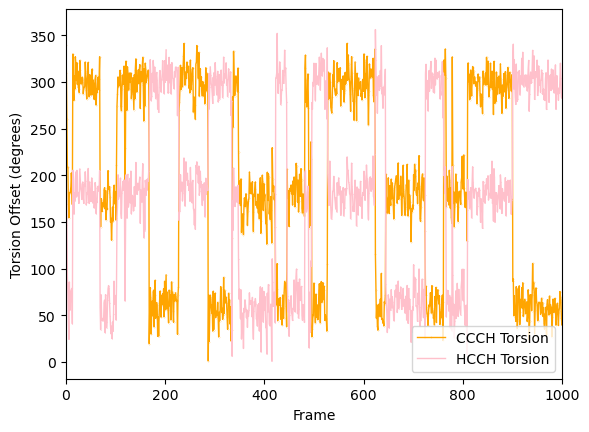

In [60]:
#print(np.where(CCCHtorsion<=0))
CCCH_tor_offset1=np.rad2deg(CCCH_torsions[:,3])
HCCH_tor_offset2=np.rad2deg(HCCH_torsions[:,11])
print(CCCH_tor_offset1, HCCH_tor_offset2)
print(CCCC_tor_offset)
for i in range(0,len(CCCH_tor_offset1)):
    if(CCCH_tor_offset1[i]<0):
        CCCH_tor_offset1[i]+=360
        
for i in range(0,len(HCCH_tor_offset2)):
    if(HCCH_tor_offset2[i]<0):
        HCCH_tor_offset2[i]+=360
# Add legend and labels
plt.xlabel('Frame')
plt.ylabel('Torsion Offset (degrees)')
# Show plot
#plt.plot(torsion1_offset, marker='x', markersize=0.1, linewidth=1, label='Torsion 1 Offset')
#plt.plot(torsion2_offset, marker='x', markersize=0.1, linewidth=1, label='Torsion 2 Offset')
plt.plot(CCCH_tor_offset1, marker='o', markersize=.1, linewidth=1, color='orange', label='CCCH Torsion')
plt.plot(HCCH_tor_offset2, marker='x', markersize=.1, linewidth=1, color='pink', label='HCCH Torsion')
plt.xlim([0,1000])
plt.legend()

Text(0.5, 0, 'frame')

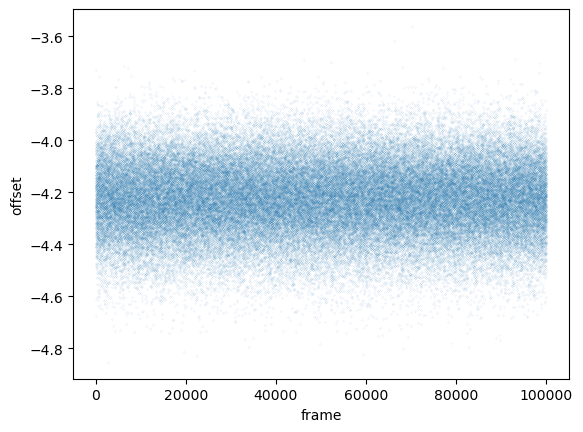

In [61]:
offset_diff = CCCH_torsions[:,3]- HCCH_torsions[:,11]
offset_diff = np.where(offset_diff>0, offset_diff - 2*np.pi, offset_diff)

plt.plot(offset_diff, marker=".",markersize=0.1, linestyle="None")
plt.ylabel("offset")
plt.xlabel("frame")

The results of the systematic offset obtained from CCCH and HCCH torsions ([54.415787 46.120663 36.836987 ... 52.453922 78.36445  58.61115 ] [-66.14827  -52.59424  -88.500626 ... -71.40288  -52.26681  -59.09088 ]), shows an offset in CCCH torsion being larger than that observed in HCCH by ~2 degree. this observation is seen in the patterns of the torsion plot above and the scatter plots.

***WEEK 2 Homework Problem #1: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

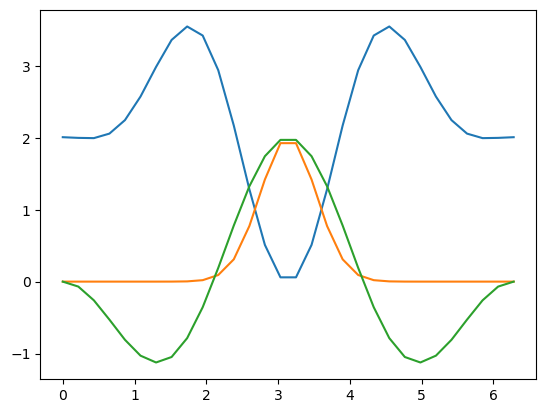

In [62]:
###SOLUTION#####

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

plt.plot(rad_ang,CCCC_e)

#We want to mimic a gaussian potential that adds potential energy when the CCCC diehdral = pi = 180 degrees
#We can think of this as approximating a guassian center at theta= 180
###Now we define a gaussian function that we'll fit to our probability densities

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#Here is what we want our dihedral correction to look like:

gauss_cor = gauss(rad_ang, 2, np.pi, np.pi/8)
plt.plot(rad_ang,gauss_cor)

#Here I come up with a correction that should have the desired effect:

def TorsionCorrection(angle):
 e1=calc_torsion_energy(angle,-1,1,0)
 e2=calc_torsion_energy(angle,1,2,0)
 #e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2

torsion_cor=TorsionCorrection(rad_ang)

plt.plot(rad_ang,torsion_cor)

***WEEK 2 Homework Problem #2 Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [ ]:
#RUN NEW MD SIMULATION HERE#

In [63]:
workdir='/Users/Keren/anaconda3/envs/Chem101_S24/Work/'
datadir='/Users/Keren/anaconda3/envs/Chem101_S24/data/'
outdir='/Users/Keren/anaconda3/envs/Chem101_S24/out/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2_cor1.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/Users/Keren/anaconda3/envs/Chem101_S24/data/butane.pdb
/Users/Keren/anaconda3/envs/Chem101_S24/data/butane.gaff2_cor1.xml


In [64]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 13.197528690534442 kJ/mol
Potential energy after minimization is 12.695271386059607 kJ/mol


In [65]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,58.13333895655572,310.7091690226499
2000,55.63767234940309,258.4061949523419


In [67]:
os.path.join(workdir, "butane_rim.xtc")

'/Users/Keren/anaconda3/envs/Chem101_S24/Work/butane_rim.xtc'

In [70]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_rim.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,35.870172860516256,412.81184525690225,0
500000,999.9999999901769,53.766921320516715,317.5478938423519,1.02e+04
750000,1499.9999999783536,70.88715299466122,254.16570941677404,9.98e+03
1000000,1999.9999999665301,69.09446181894286,198.19775912198207,9.95e+03
1250000,2499.9999999547067,73.94565772581342,220.59200991470712,9.96e+03
1500000,2999.9999999428833,36.86874263312551,254.54008693291985,1.01e+04
1750000,3499.99999993106,44.35943213353846,242.72710514874112,9.47e+03
2000000,3999.9999999192364,54.22031539822792,235.7490456899226,9.22e+03
2250000,4499.9999999992715,38.61150367995067,359.95284839803907,9.17e+03
2500000,5000.000000101135,55.966606032325274,432.3831227645701,8.94e+03
2750000,5500.000000202998,58.02336353471688,222.1520213658553,8.92e+03
3000000,6000.000000304862,46.752429220324046,290.82008178234526,8.97e+03
3250000,6500.000000406725,41.463343

In [71]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_rim.xtc"), top=PDB_file_name)
traj

<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x2598cb471d0>

In [72]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [73]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x2598dbca590>

In [74]:
C_sel=top.select("type C")
print(C_sel)
top.atom(10)
for atom in C_sel:
    print(atom,top.atom(atom))

H_sel=top.select("type H")
for atom in H_sel:
    print(atom,top.atom(atom))

[ 0  4  7 10]
0 NBU1-C1
4 NBU1-C2
7 NBU1-C3
10 NBU1-C4
1 NBU1-H11
2 NBU1-H12
3 NBU1-H13
5 NBU1-H21
6 NBU1-H22
8 NBU1-H31
9 NBU1-H32
11 NBU1-H41
12 NBU1-H42
13 NBU1-H43


In [76]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


(100000, 2)
[[1.9081882 1.8881474]
 [1.8865883 2.0217302]
 [1.9264784 2.0597014]
 ...
 [2.043026  2.0155373]
 [2.001764  1.9012007]
 [1.9937968 1.8712579]]


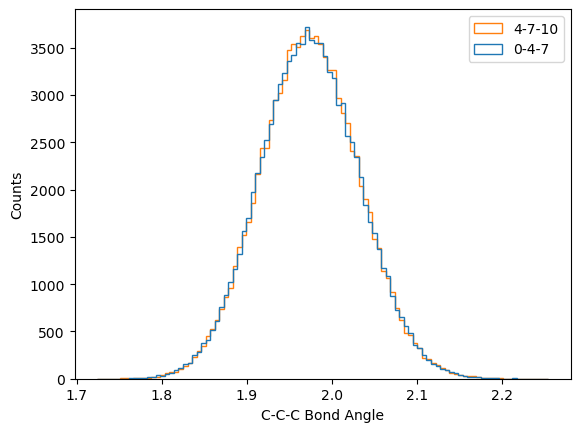

[[ 2.8830633]
 [-3.1324246]
 [ 2.9522889]
 ...
 [-2.7729928]
 [ 2.7410312]
 [ 2.9433007]]
[[ 165.18735]
 [-179.4747 ]
 [ 169.15369]
 ...
 [-158.88078]
 [ 157.04951]
 [ 168.6387 ]]


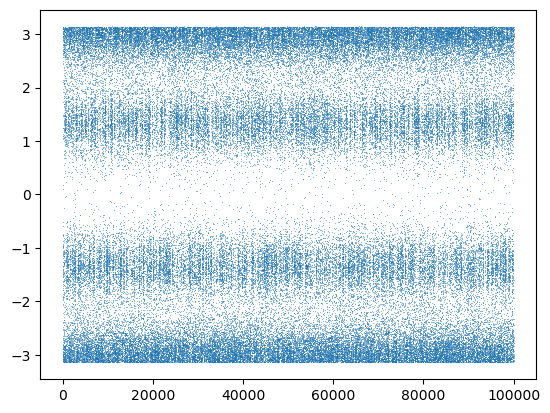

In [77]:
###Class Room Solution###
##Lets Compute Some Bond Angles & Torsions##
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
print(np.shape(ang))
print(ang)

ang1=ang[:,0]
ang2=ang[:,1]

plt.plot(ang1,linewidth=0,marker='x',markersize=.1)
plt.plot(ang2,linewidth=0,marker='x',markersize=.1)
plt.clf()

plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle')
plt.ylabel('Counts')
plt.show()
#plt.scatter(ang1,marker='o',s=0.1)

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
print(CCCC_torsion)
print(np.rad2deg(CCCC_torsion))

plt.plot(CCCC_torsion,marker='x',markersize=.1,linewidth=0)
#plt.xlim([0,100])

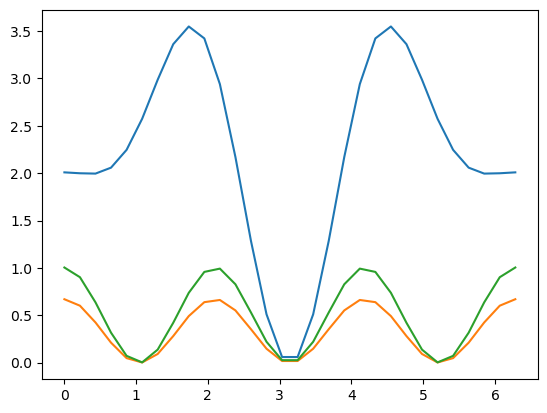

In [78]:
#Class Example

### Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms

#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCH_e)
plt.plot(rad_ang,HCCH_e)

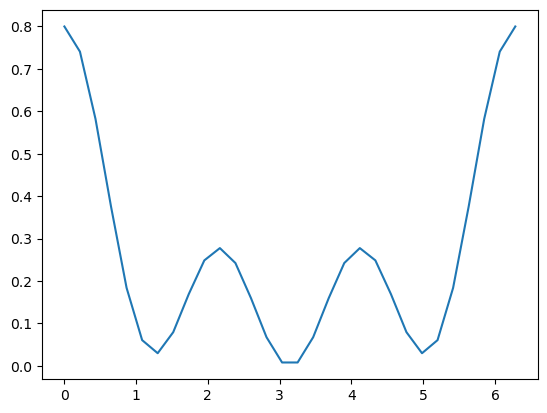

In [79]:
## Homework trial 1
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms

#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.2,3,0)
 e2=calc_torsion_energy(angle,-0.1499,2,3.1416)
 e3=calc_torsion_energy(angle,0.2,1,0)
 return e1+e2+e3

CCCC_e=CCCC_torsionE(rad_ang)

plt.plot(rad_ang,CCCC_e)

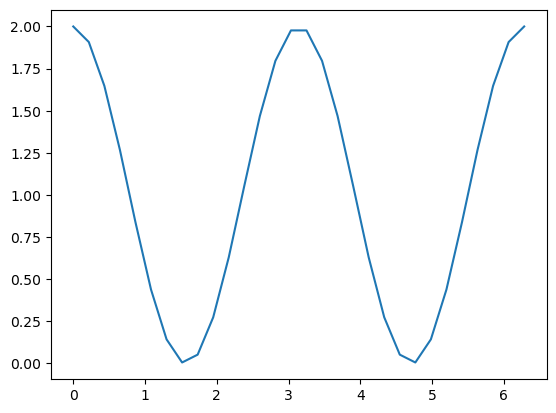

In [80]:
## Homework trial 2
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms

#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,-3,1,1.0472)
 e2=calc_torsion_energy(angle,1,2,6.2832)
 e3=calc_torsion_energy(angle,3,1,1.0472)
 return e1+e2+e3

#def CCCH_torsionE(angle):
# e1=calc_torsion_energy(angle,0.3347,3,0)
 #return e1

#def HCCH_torsionE(angle):
 #e1=calc_torsion_energy(angle,0.50208,3,0)
 #return e1

CCCC_e=CCCC_torsionE(rad_ang)
#CCCH_e=CCCH_torsionE(rad_ang)
#HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
#plt.plot(rad_ang,CCCH_e)
#plt.plot(rad_ang,HCCH_e)

In [81]:
#Compare New Dihedral Distribution HERE)
workdir='/Users/Keren/anaconda3/envs/Chem101_S24/Work/'
datadir='/Users/Keren/anaconda3/envs/Chem101_S24/data/'
outdir='/Users/Keren/anaconda3/envs/Chem101_S24/out/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2_cor1.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)


/Users/Keren/anaconda3/envs/Chem101_S24/data/butane.pdb
/Users/Keren/anaconda3/envs/Chem101_S24/data/butane.gaff2_cor1.xml


In [82]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 13.197528690534442 kJ/mol
Potential energy after minimization is 12.695271386059607 kJ/mol


In [83]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,43.449070274805024,288.98124820446355
2000,51.42495603077862,177.75957959636713


In [84]:
os.path.join(workdir, "butane_cor1.xtc")

'/Users/Keren/anaconda3/envs/Chem101_S24/Work/butane_cor1.xtc'

In [85]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_cor1.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,54.396565073985606,261.572055691297,--
500000,999.9999999901769,48.782985624450916,355.48267490090404,9.2e+03
750000,1499.9999999783536,50.92093161012595,443.89011869947007,8.73e+03
1000000,1999.9999999665301,57.13559165835889,380.96777827230403,8.88e+03
1250000,2499.9999999547067,47.67835034470332,382.373373503809,9.08e+03
1500000,2999.9999999428833,49.43918979285027,198.6222782171172,8.8e+03
1750000,3499.99999993106,57.973328410566616,382.0878756112366,8.88e+03
2000000,3999.9999999192364,39.98905096029914,421.6486723694523,8.75e+03
2250000,4499.9999999992715,54.93070924235259,304.5187537275064,8.45e+03
2500000,5000.000000101135,38.708997177663264,287.1526669277756,8.55e+03
2750000,5500.000000202998,33.46504435814454,391.623906198055,8.63e+03
3000000,6000.000000304862,34.03714717784548,229.11706895008967,8.65e+03
3250000,6500.000000406725,71.97455144059191

In [86]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_cor1.xtc"), top=PDB_file_name)
traj

<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x2598cc032d0>

In [87]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

[0.53740277 0.25639851 0.09393328 0.06722705 0.12595522 0.23685438
 0.18360117 0.06700423 0.01811183 0.00572958 0.00576141 0.01693409
 0.06967803 0.18376033 0.23491269 0.13041156 0.06668592 0.09040004
 0.25668499 0.53565206] [-3.1415925  -2.8274333  -2.513274   -2.1991148  -1.8849555  -1.5707963
 -1.256637   -0.94247776 -0.6283185  -0.31415924  0.          0.31415924
  0.6283185   0.94247776  1.256637    1.5707963   1.8849555   2.1991148
  2.513274    2.8274333   3.1415925 ]
[1.02416242e+00 2.00248668e-01 2.18042183e-02 7.67127095e-03
 2.73109875e-02 1.16851556e-01 1.46008741e-01 3.95022558e-02
 3.85154952e-03 4.45633828e-04 5.09295804e-04 3.40591569e-03
 4.13802841e-02 1.52852403e-01 1.23217754e-01 2.63878888e-02
 7.44845396e-03 2.07537961e-02 2.04068385e-01 1.01521791e+00] [-3.1415927  -2.8274336  -2.5132742  -2.1991148  -1.8849556  -1.5707964
 -1.2566371  -0.9424778  -0.62831855 -0.31415927  0.          0.31415927
  0.62831855  0.9424778   1.2566371   1.5707964   1.8849556   2.19911

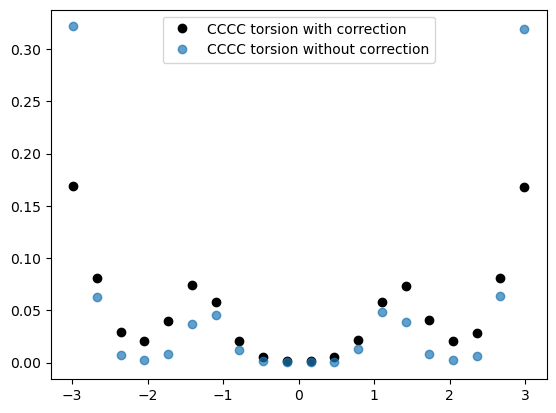

In [88]:
#Compare New Dihedral Distribution HERE)

# With Correction
traj_add_correction = md.load(os.path.join(workdir, "butane_cor1.xtc"), top=PDB_file_name)
CCCC_torsion_c = md.compute_dihedrals(traj_add_correction, [CCCC_index])
centers, density = histogram_bincenters(CCCC_torsion_c[:,0], 20)  # Removed the third argument
plt.plot(centers, density, "o", label="CCCC torsion with correction", color="black")

#Without Correction
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)
CCCC_torsion = md.compute_dihedrals(traj, [CCCC_index])
centers, density = histogram_bincenters(CCCC_torsion[:,0], 20)  # Removed the third argument
plt.plot(centers, density, "o", label="CCCC torsion without correction", color="tab:blue", alpha=0.7)

plt.legend()



**WEEK 2 Homework Problem #3 Plot the LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

#CHECK THE COMBINATION RULES USED FOR OPENMM##

In [89]:
#Plot LJ and Couloumb Potentionals Here

# Define LJ and Coulomb functions
def lj(r, sigma, epsilon):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

def coulomb(q1, q2, r, dielectric_constant=1.0):
    return (1.0 / (4 * np.pi * dielectric_constant)) * q1 * q2 / r

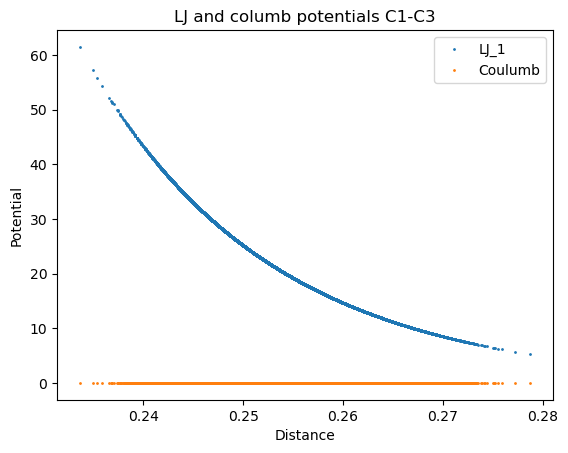

In [90]:
# Distance between between carbons 1 and 3 [0, 7] atom types [0,1]
atom_pair = np.array([[0, 7]])
distances = md.compute_distances(traj, atom_pair, periodic=True)

def lj(r, sigma1, epsilon1, sigma2, epsilon2):
    return 4 * np.sqrt(epsilon1 * epsilon2) * ((sigma1 + sigma2) / (2 * r))**12 - ((sigma1 + sigma2) / (2 * r))**6
   
# Define Coulomb function
def coulomb(qa, qb, r, dielectric_constant=1.0):
    return (1.0 / (4 * np.pi * dielectric_constant)) * qa * qb / r

# Defining the atom indices and their corresponding sigma and epsilon values
sigma_a = 0.3397710  # Sigma value for the first atom
epsilon_a = 0.4510352  # Epsilon value for the first atom
sigma_b = 0.3397710 # Sigma value for the second atom
epsilon_b = 0.0870272  # Epsilon value for the second atom

qa = -0.0932 # Charge of the first atom
qb = -0.0814  # Charge of the second atom

lj_potentials = lj(distances, sigma_a, epsilon_a, sigma_b, epsilon_b)
coulomb_potentials = coulomb(qa, qb, distances)

plt.plot(distances, lj_potentials, linestyle="None", marker="o", markersize=1.0, label="LJ_1")
plt.plot(distances, coulomb_potentials, linestyle="None", marker="o", markersize=1.0, label="Coulumb")
plt.title('LJ and columb potentials C1-C3')
plt.xlabel("Distance")
plt.ylabel("Potential")
plt.legend()

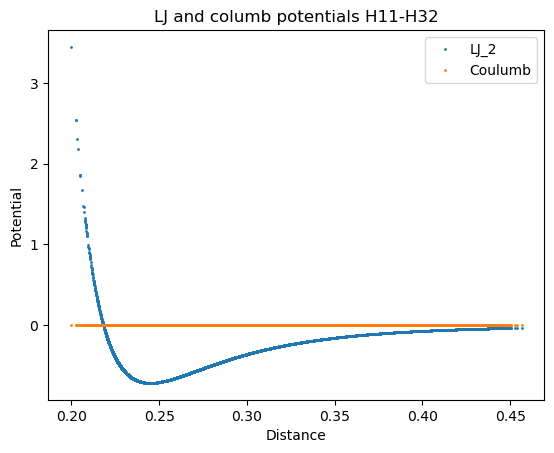

In [91]:
# Distance between between hydrogens 11 and 32 [1, 9] atom types [2,3]
atom_pair = np.array([[1, 9]])
distances = md.compute_distances(traj, atom_pair, periodic=True)

def lj(r, sigma1, epsilon1, sigma2, epsilon2):
    return 4 * np.sqrt(epsilon1 * epsilon2) * ((sigma1 + sigma2) / (2 * r))**12 - ((sigma1 + sigma2) / (2 * r))**6
   
# Define Coulomb function
def coulomb(qa, qb, r, dielectric_constant=1.0):
    return (1.0 / (4 * np.pi * dielectric_constant)) * qa * qb / r

# Defining the atom indices and their corresponding sigma and epsilon values
sigma_a = 0.2600177  # Sigma value for the first atom
epsilon_a = 0.0870272  # Epsilon value for the first atom
sigma_b = 0.2600177 # Sigma value for the second atom
epsilon_b = 0.0870272  # Epsilon value for the second atom

qa = 0.0324 # Charge of the first atom
qb = 0.0387  # Charge of the second atom

lj_potentials = lj(distances, sigma_a, epsilon_a, sigma_b, epsilon_b)
coulomb_potentials = coulomb(qa, qb, distances)

plt.plot(distances, lj_potentials, linestyle="None", marker="o", markersize=1.0, label="LJ_2")
plt.plot(distances, coulomb_potentials, linestyle="None", marker="o", markersize=1.0, label="Coulumb")
plt.title('LJ and columb potentials H11-H32')
plt.xlabel("Distance")
plt.ylabel("Potential")
plt.legend()

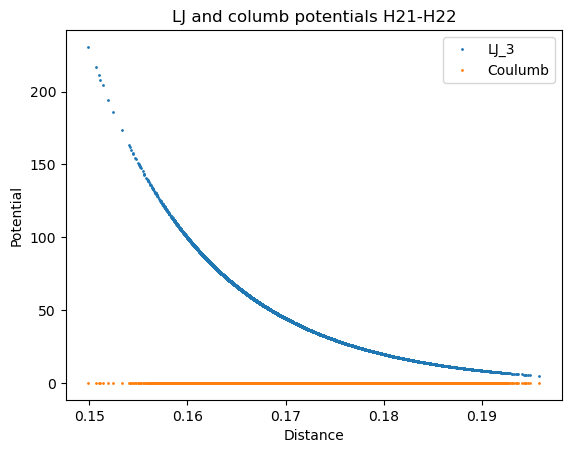

In [92]:
# Distance between between hydrogens 21 and 22 [5, 6] atom types [3]
atom_pair = np.array([[5, 6]])
distances = md.compute_distances(traj, atom_pair, periodic=True)

def lj(r, sigma1, epsilon1, sigma2, epsilon2):
    return 4 * np.sqrt(epsilon1 * epsilon2) * ((sigma1 + sigma2) / (2 * r))**12 - ((sigma1 + sigma2) / (2 * r))**6
   
# Define Coulomb function
def coulomb(qa, qb, r, dielectric_constant=1.0):
    return (1.0 / (4 * np.pi * dielectric_constant)) * qa * qb / r

# Defining the atom indices and their corresponding sigma and epsilon values
sigma_a = 0.2600177  # Sigma value for the first atom
epsilon_a = 0.0870272  # Epsilon value for the first atom
sigma_b = 0.2600177 # Sigma value for the second atom
epsilon_b = 0.0870272  # Epsilon value for the second atom

qa = 0.0387 # Charge of the first atom
qb = 0.0387  # Charge of the second atom

lj_potentials = lj(distances, sigma_a, epsilon_a, sigma_b, epsilon_b)
coulomb_potentials = coulomb(qa, qb, distances)

plt.plot(distances, lj_potentials, linestyle="None", marker="o", markersize=1.0, label="LJ_3")
plt.plot(distances, coulomb_potentials, linestyle="None", marker="o", markersize=1.0, label="Coulumb")
plt.title('LJ and columb potentials H21-H22')
plt.xlabel("Distance")
plt.ylabel("Potential")
plt.legend()